# Chapter 5. Pretraining on Unlabelled Data

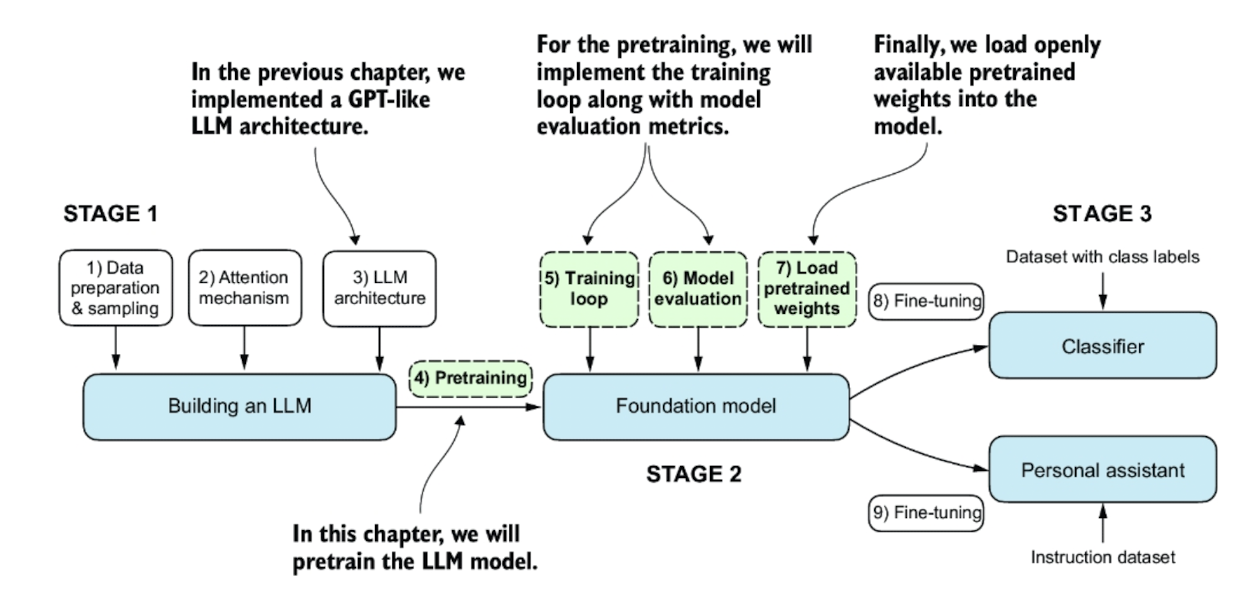

- Weight parameters -->
- Pytorch allow access to the parameters by `layer.weight`, also pytorch allow access to trainable parameters as `model.parameters()`

## 5.1 Evaluating the generative text models


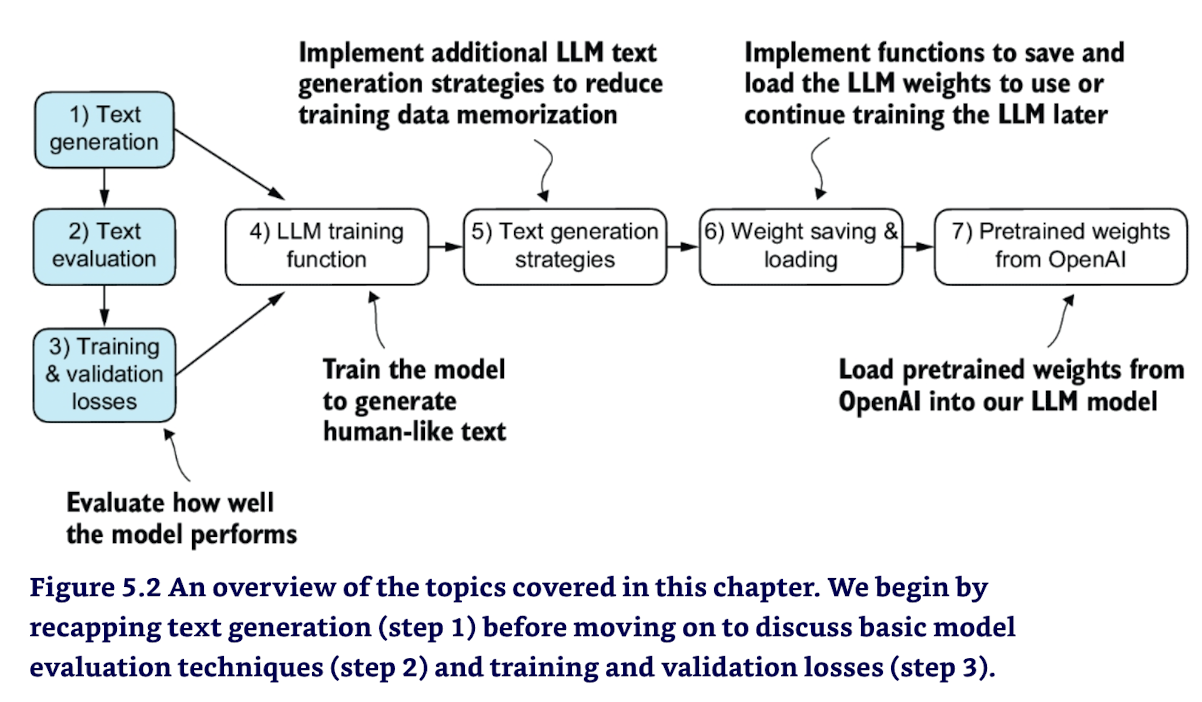

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.7.0
tensorflow version: 2.19.0


### 5.1.1 Using GPT to generate text

In [2]:
import torch
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate (its possible that : --> common dropout rate is zero)
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() # disable dropout during dropout

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- original GPT-2 has context size of 1024, later we will update it when we laod the weights to this setting otherwise to run we will use context_length of 256.
- `generate_simple_text` introduce the two main simple functions : `text_to_token_ids` and `token_ids_to_text`
  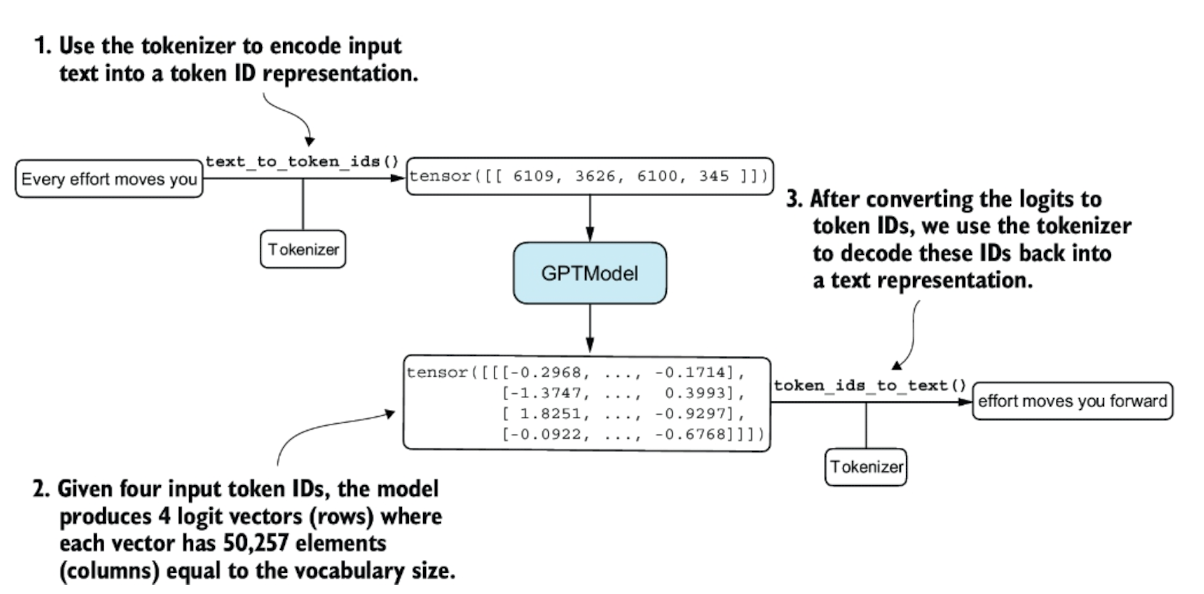


In [3]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- Its not producing coherent text as its not undergone the training.

### 5.1.2 Calculation of text generation loss

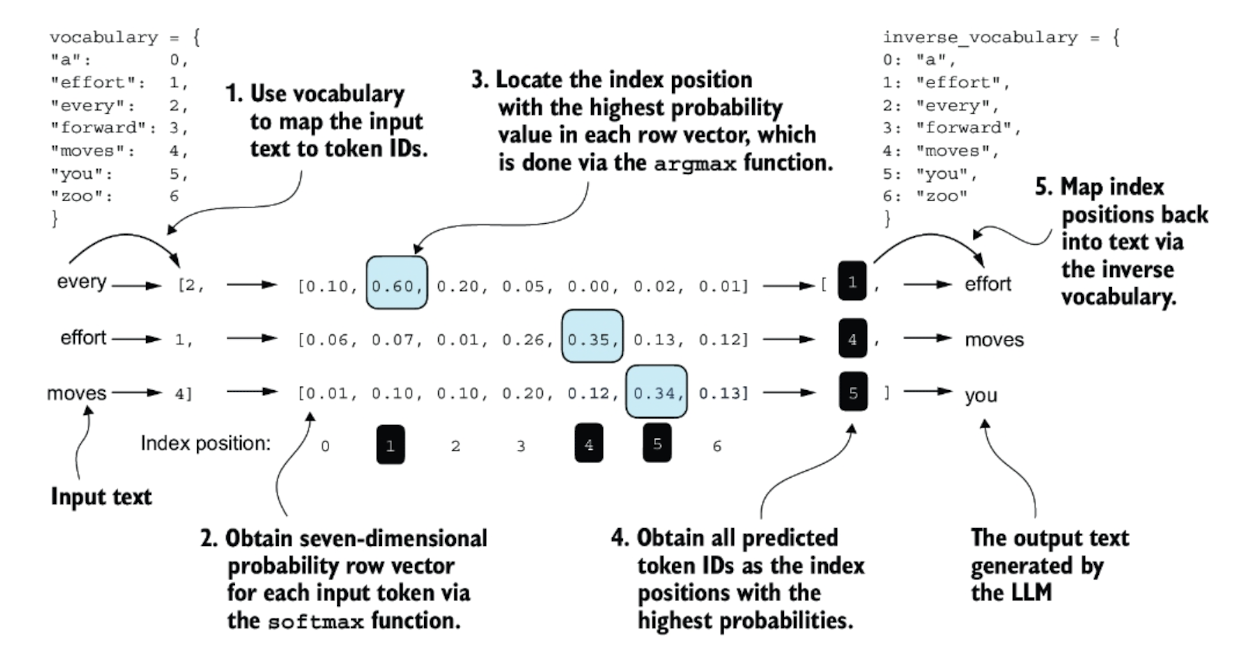

- Our GPT works with vocabulary size of `50,257` Hence the token IDs will be from  0 to 50,256.


In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

- We want model to produce

In [5]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- Feeding the `inputs` to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each
- Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary
- Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores 

In [6]:
with torch.no_grad(): # Disable gradient tracking since we are not training yet
    logits = model(inputs)

probas = torch.softmax(logits, dim = -1) # Probability of each token in vocabulary
print(probas.shape)
    

torch.Size([2, 3, 50257])


- 2 --> 2 samples (rows) also known as batch size
- 3 --> corresponds to the number of tokens in each example
- 50257 -->Last number corresponds to the embedding dimensions.

- As discussed in the previous chapter, we can apply the `argmax` function to convert the probability scores into predicted token IDs
- The softmax function above produced a 50,257-dimensional vector for each token; the `argmax` function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token

In [7]:
token_ids = torch.argmax(probas, dim= -1 , keepdim= True)
print("Token ids : \n", token_ids)

Token ids : 
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:
- If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens:


In [8]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


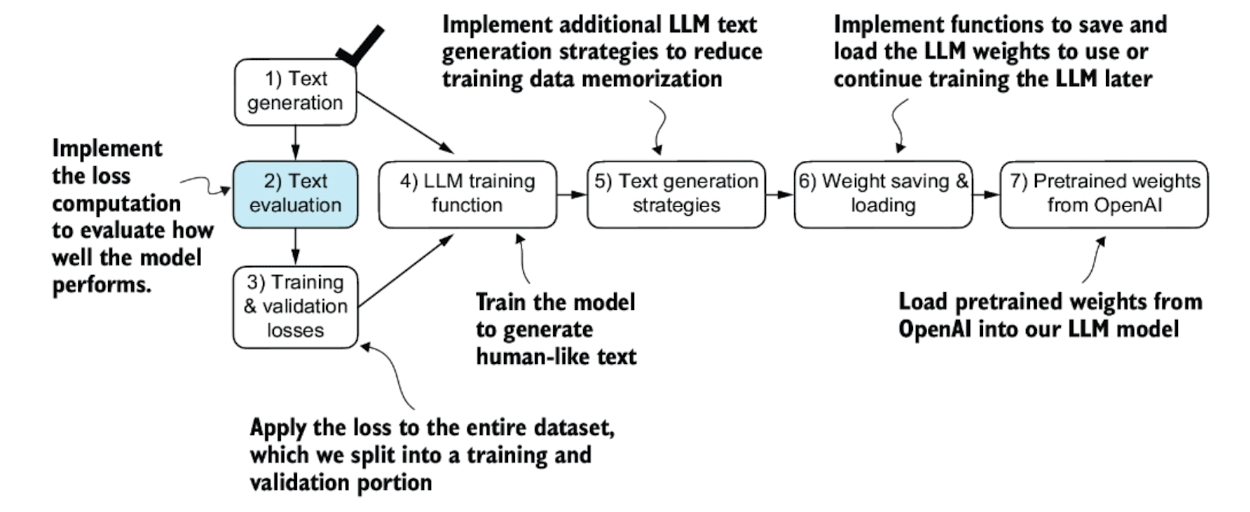

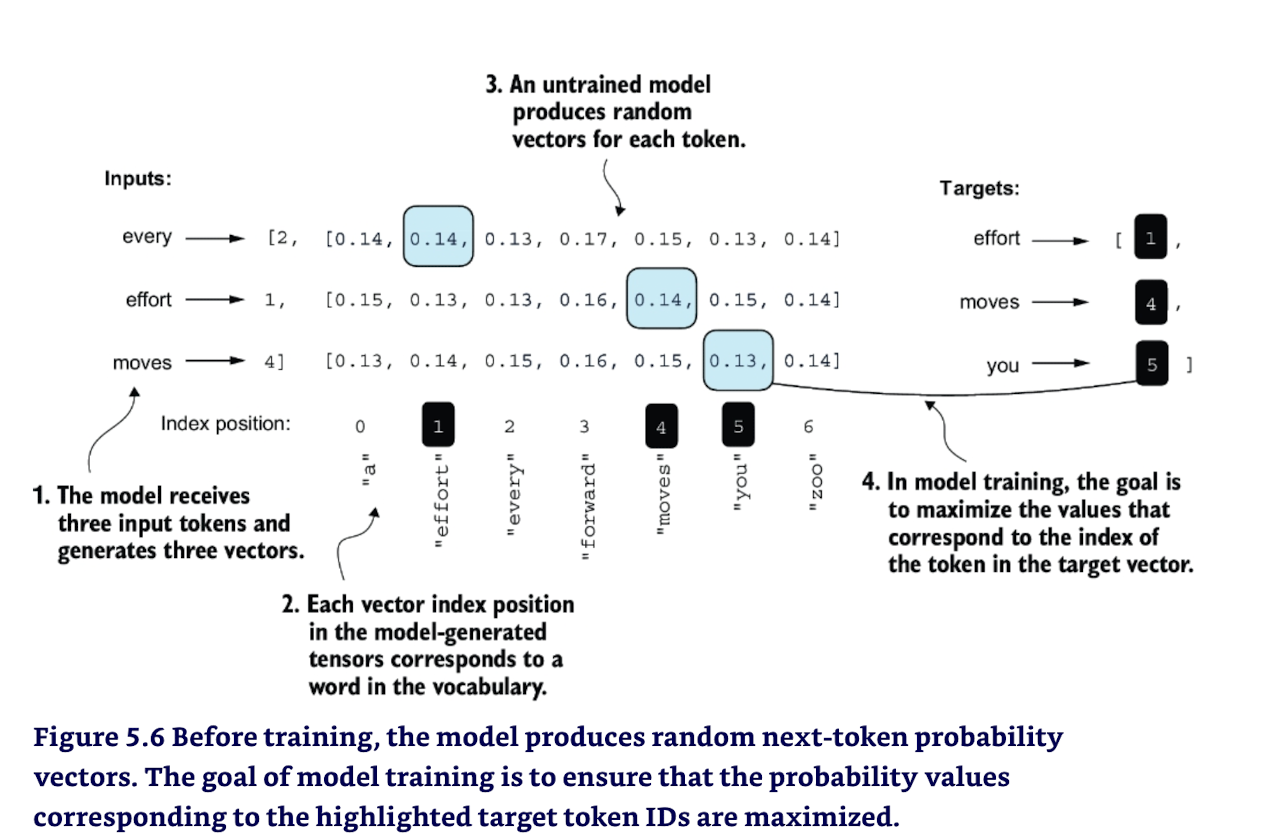

In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- We want to maximize all these values, bringing them close to a probability of 1
- In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself; this is out of the scope of this book, but I have recorded a lecture with more details here: [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [10]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- Next, we compute the average log probability:


In [11]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- The goal is to make this average log probability as large as possible by optimizing the model weights
- Due to the log, the largest possible value is 0, and we are currently far away from 0

- In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the *negative* average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
- The value negative of -10.7722, i.e., 10.7722, is also called `cross-entropy` loss in deep learning

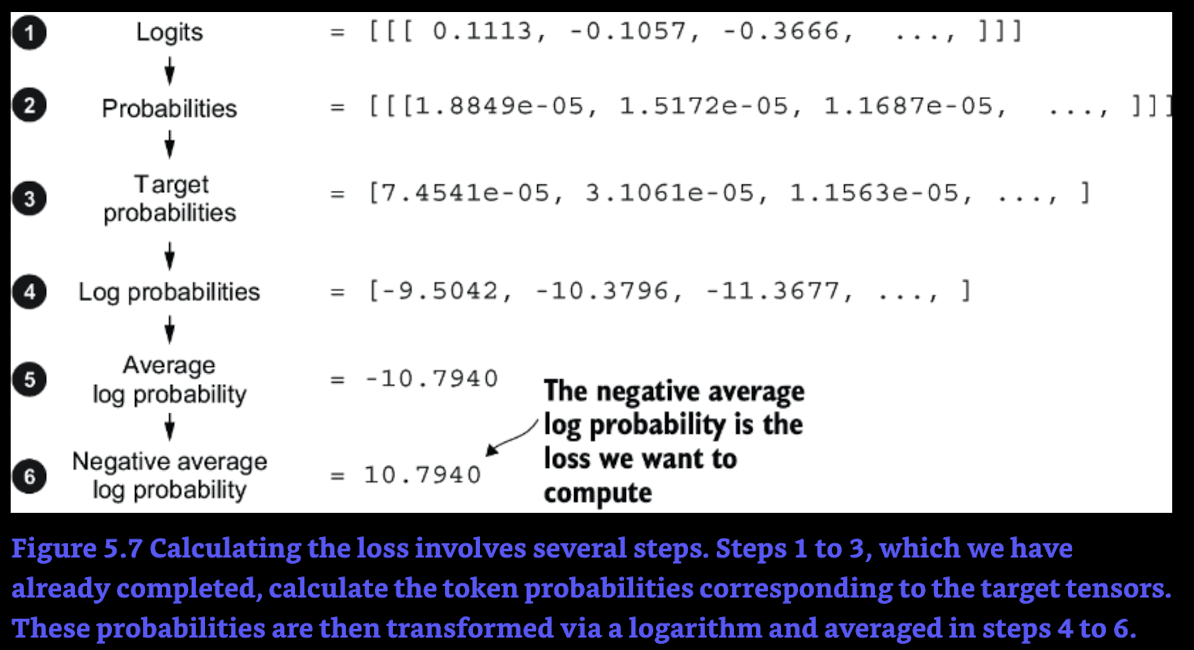

In [12]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- Before we apply the `cross_entropy` function, let's check the shape of the logits and targets


In [13]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [14]:
logits

tensor([[[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
         [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
         [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217]],

        [[-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
         [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
         [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]]])

In [15]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

- For the `cross_enctropy` Loss function in Pytorch, we want to flatten these tensors by combining them over the batch dimension

In [16]:
logits_flat = logits.flatten(0,1)
print(logits_flat)
print("Flatten logits :", logits_flat.shape)

tensor([[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
        [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
        [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217],
        [-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
        [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
        [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]])
Flatten logits : torch.Size([6, 50257])


In [17]:
targets_flat = targets.flatten()
print("Flatten targets:", targets_flat.shape)

Flatten targets: torch.Size([6])


In [18]:
targets_flat

tensor([ 3626,  6100,   345,  1107,   588, 11311])

- Remember logits are the Token IDs which we want LLM to generate and logits contain unscaled outputs before they enter the softmax function.
- Previously we applied `softmax` function on logits to obtain the probability scores, corresponding to the target ids and computed the negative average log probabilities.
- Pytorch Cross Entropy will take care of this for us. ( But there may be problem in applying the stable max) lets see.
- Write a function cross entropy or investigate the Pytorch `cross_entropy`.

In [19]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### Perplexity


- Perplexity is the measure often used along side the cross entropy to evaluate the LLM model performance.
- It provide more interpretability
- Perplexity measures the how well the probility distribution pridicted by the model matched the actual distribution of the words in the dataset.
- Similar to the loss lower perplexity values indicate predicted distribution is closer to the actual.
- perplexity can be calculated as `perplexity = torch.exp(loss)`
- It considered more interpretable as the raw loss value because it signifies the effective vocabulary size about which model is uncertain at each step. 

In [20]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- The perplexity = 48725 words or token model is uncertain at this step.
- Model is quite uncertain yet out of 50,257 words it is uncertain about 48k words/tokens.

### 5.1.3 Calculating the training and validation set loss

- We must prepare the training and validation dataset which we will use to train the LLM
  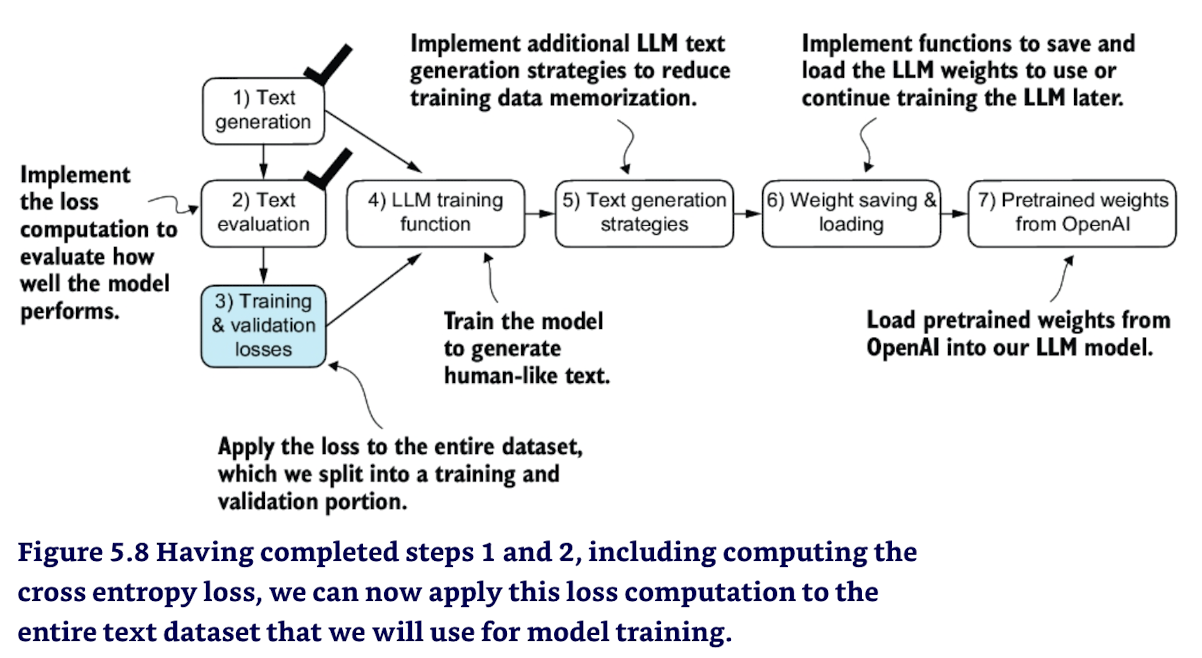

- We use a relatively small dataset for training the LLM (in fact, only one short story)
- The reasons are:
  - You can run the code examples in a few minutes on a laptop computer without a suitable GPU
  - The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
  - We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size


- For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens
  - At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately \\$30
  - So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * \\$30 =  \\$690,000
 
- Below, we use the same dataset we used in chapter 2

In [21]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

- After loading the dataset you can check the number of tokens and charachters in the dataset

In [22]:
total_characters = len(text_data) 
total_tokens = len(tokenizer.encode(text_data))
print("Total Characters:",total_characters)
print("Total token:", total_tokens)

Total Characters: 20479
Total token: 5145


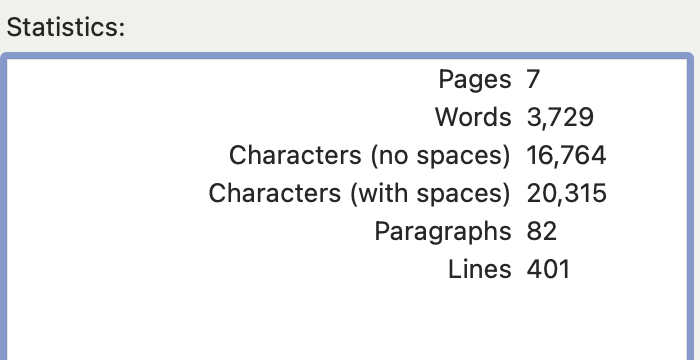
- Words has not included the extra/special characters.
- A quick check that the text loaded ok by printing the first and last 100 words

In [23]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [24]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


- Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the `max_length` equal to the context length that the LLM supports
- The figure below only shows the input tokens for simplicity
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

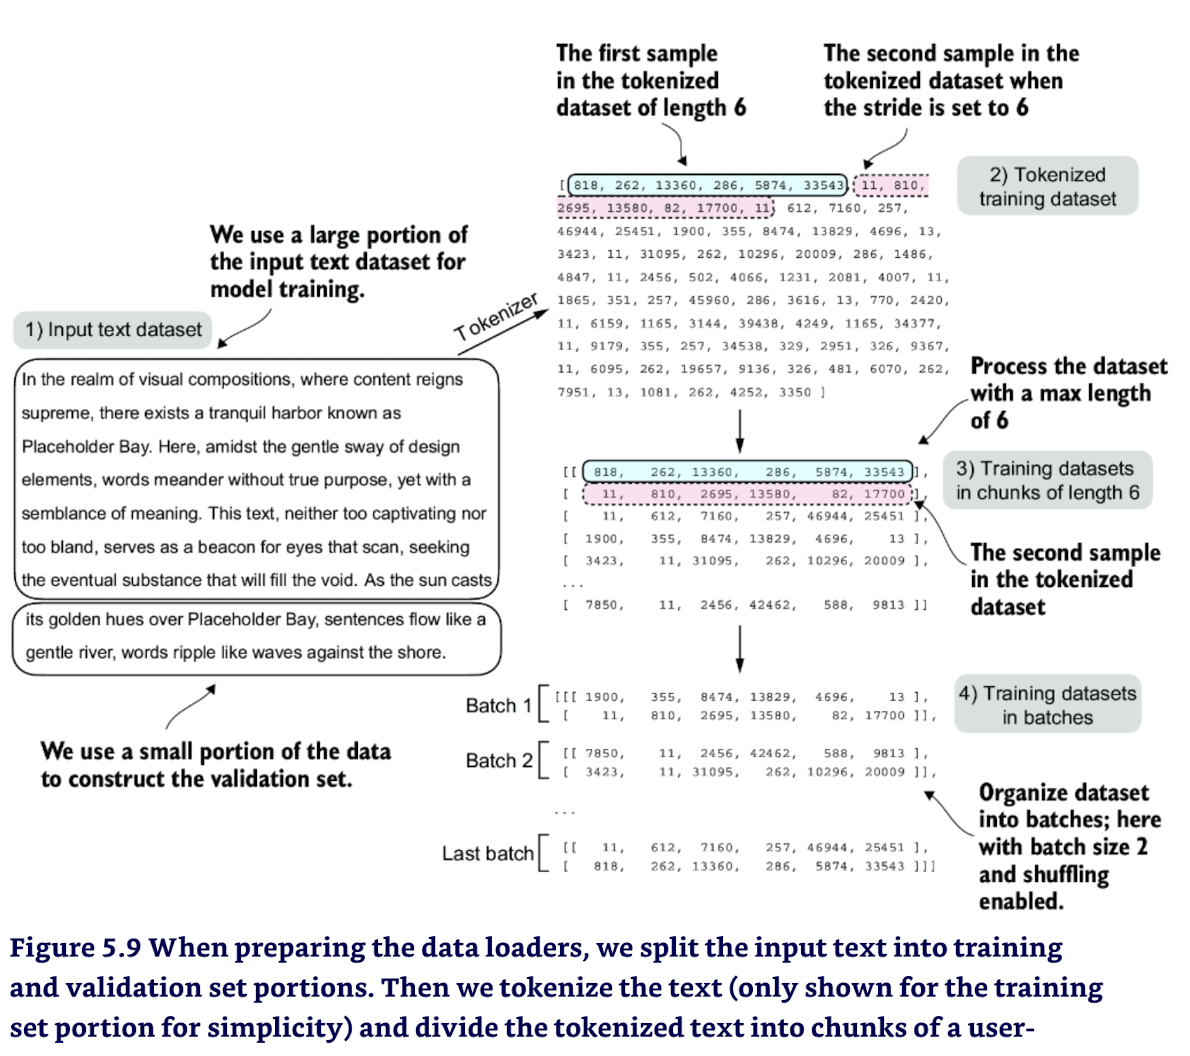
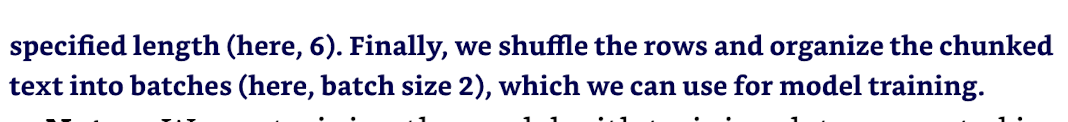

- Here we are training model with fix chunck size but in practice it is useful to train on varying size of chunck size for better generalizability.
- To implement the Data spliting and loading, we first define the train ratio to use 90% of data for training and remaining 10% as validation data for model evaluation during training.

In [25]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [26]:
split_idx

18431

- using the `train_data` and `val_data` subset, we can now create the respective data loader reusing the `create_dataloader_v1`

In [27]:
from previous_chapters import create_dataloader_v1
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

- We use the smaller batch size to reduce the computational resources, because we are working with very small dataset.
- In practice training LLMs with batch size of 1024 or larger is common.

In [28]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- An optional check that the data was loaded correctly:

In [29]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- we have 9 training batches, with 2 tokens each and 256 tokens each.
- Another optional check that the token sizes are in the expected ballpark:


In [30]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- Next, we implement a utility function to calculate the cross-entropy loss of a given batch
- In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [31]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

# if torch.cuda.is_available():
#    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#    device = torch.device("mps")
# else:
#    device = torch.device("cpu")

# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


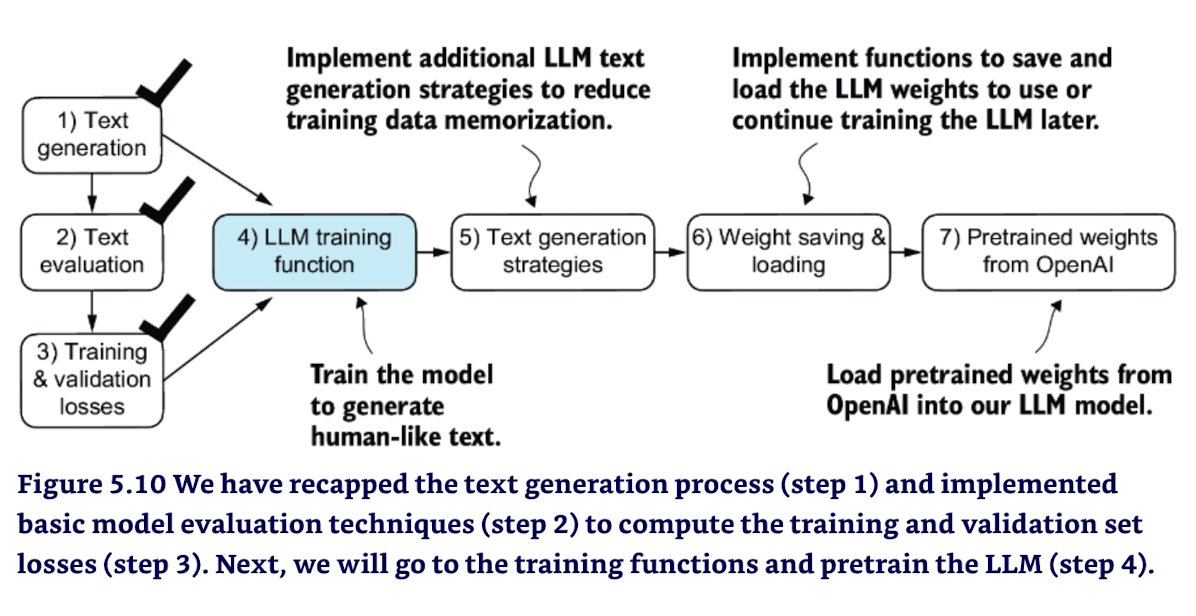

# 5.2 Training an LLM

Note : Read Appendix D: for advance training techniques :
- including learning rate warmup, cosine annealing, and gradient clipping
  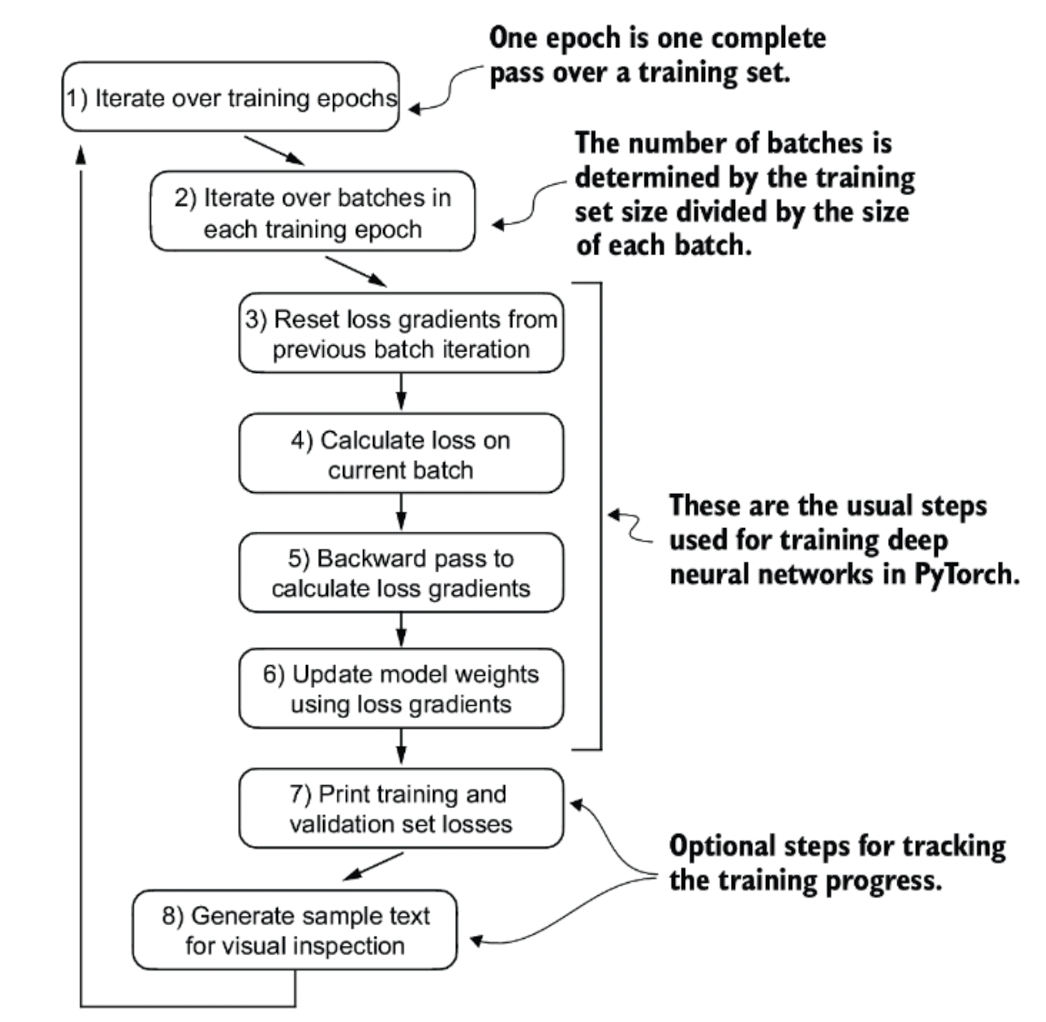

- One epoch is the complete pass over training set

In [33]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_token_seen = [],[],[] # 1. Initialize the list to track losses and token seen
    
    token_seen, global_step = 0, -1

    for epoch in range(num_epochs): # 2. Start the main training loop.
        
        model.train() # set the model to train
        
        for input_batch, target_batch in train_loader:
            
            optimizer.zero_grad() # 3. Reset loss gradient from previous batch iteration
            
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            loss.backward()  # 4. Calculate the loss gradients
            
            optimizer.step() # 5. Update the model weights using the loss gradient.
            
            token_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:  # 6. Optional evaluation step

                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen.append(token_seen)

                print(f"Ep {epoch+1} (step {global_step:06d}):"
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}"
                     )
        # 7. print sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_token_seen
            

In [34]:
# def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
#                        eval_freq, eval_iter, start_context, tokenizer):
#     # Initialize lists to track losses and tokens seen
#     train_losses, val_losses, track_tokens_seen = [], [], []
#     tokens_seen, global_step = 0, -1

#     # Main training loop
#     for epoch in range(num_epochs):
#         model.train()  # Set model to training mode
        
#         for input_batch, target_batch in train_loader:
#             optimizer.zero_grad() # Reset loss gradients from previous batch iteration
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward() # Calculate loss gradients
#             optimizer.step() # Update model weights using loss gradients
#             tokens_seen += input_batch.numel()
#             global_step += 1

#             # Optional evaluation step
#             if global_step % eval_freq == 0:
#                 train_loss, val_loss = evaluate_model(
#                     model, train_loader, val_loader, device, eval_iter)
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 track_tokens_seen.append(tokens_seen)
#                 print(f"Ep {epoch+1} (Step {global_step:06d}): "
#                       f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

#         # Print a sample text after each epoch
#         generate_and_print_sample(
#             model, tokenizer, device, start_context
#         )

#     return train_losses, val_losses, track_tokens_seen

- We haven't defined yet two above functions `evaluate_model` and `generate_and_print_sample`
- evaluate_model --> print the training and validation set after each model update. So that we can evaluate weather training improves the model.
- More specifically, model is in eval mode, where gradient tracking and dropout is disabled, when calculating the losses over the trainng and validation set.

In [35]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # 1. Dropout is disabled for stable and reproducible results.
    with torch.no_grad():   # 2. Disable gradient tracking, which is not required during evaluation, to reduce the computational head.

        train_loss = calc_loss_loader(
            train_loader,model, device, num_batches = eval_iter
        )

        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter)
        model.train()

        return train_loss, val_loss
        

In [36]:
# this function track weather model improves during the training
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx = encoded,
            max_new_tokens= 50, context_size = context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)

        print(decoded_text.replace("\n", " ")) # compact print format
        model.train()
        

In [37]:
# def evaluate_model(model, train_loader, val_loader, device, eval_iter):
#     model.eval()
#     with torch.no_grad():
#         train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
#         val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
#     model.train()
#     return train_loss, val_loss


# def generate_and_print_sample(model, tokenizer, device, start_context):
#     model.eval()
#     context_size = model.pos_emb.weight.shape[0]
#     encoded = text_to_token_ids(start_context, tokenizer).to(device)
#     with torch.no_grad():
#         token_ids = generate_text_simple(
#             model=model, idx=encoded,
#             max_new_tokens=50, context_size=context_size
#         )
#     decoded_text = token_ids_to_text(token_ids, tokenizer)
#     print(decoded_text.replace("\n", " "))  # Compact print format
#     model.train()

- `evaluate_model` : Gives us the numeric estimate of training progress.
- `generate_and_print_sample` : provides us concrete text example generated by the model to judge the capability during the training.

## ADAMW
Adam is popular choice to for training the Deep neural networks.
But we used AdamW as it improves the weight decay approach. which aims to minimise the model complexity and prevent the oerfitting by penalising the large weights. This adjustment allows the adamW more effective reguralization and better generalization. Thus AdamW is frequently used in LLM training.


Lets run the model for 10 epochs

# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Note : 
So, eval_freq is "how often", eval_iter is "how much".

****What is a batch?****
- A batch is a small group of samples processed together before updating model weights.

You break your training data into batches to speed up training.

****What is an iteration?****
- iteration usually means processing one batch.

So, 1 iteration = 1 batch processed.

****What is an epoch?****
- Epoch = when your model has seen all batches in the training set once.

Now, the parameters:
1. `eval_freq = 5`
- Means: How often to do evaluation during training.

Example: Every 5 iterations (5 batches), stop and check how your model is doing (calculate loss on train and validation).

2. `eval_iter = 5`
- Means: How many batches to use for calculating the average loss during each evaluation.

    - At every 5th iteration (eval_freq=5), you pause and check performance.

    - During this evaluation, you only look at 5 batches (eval_iter=5) instead of the entire train/val set.

- Note that you might get slightly different loss values on your computer, which is not a reason for concern if they are roughly similar (a training loss below 1 and a validation loss below 7)
- Small differences can often be due to different GPU hardware and CUDA versions or small changes in newer PyTorch versions
- Even if you are running the example on a CPU, you may observe slight differences; a possible reason for a discrepancy is the differing behavior of `nn.Dropout` across operating systems, depending on how PyTorch was compiled, as discussed [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

KeyboardInterrupt: 

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- However, based on the training and validation set losses, we can see that the model starts ***overfitting***
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data
- Later, we will cover decoding strategies that can mitigate this memorization by a certain degree
- Note that the ***overfitting*** here occurs because we have a ***very, very small training set***, and we iterate over it so many times
  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - ***Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later***

- Appendix B, to train model on larger dataset. --> Project GutenBerg.
- **If you are interested in augmenting this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping, please refer to [Appendix D](../../appendix-D/01_main-chapter-code)**
- **If you are interested in a larger training dataset and longer training run, see [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**


  

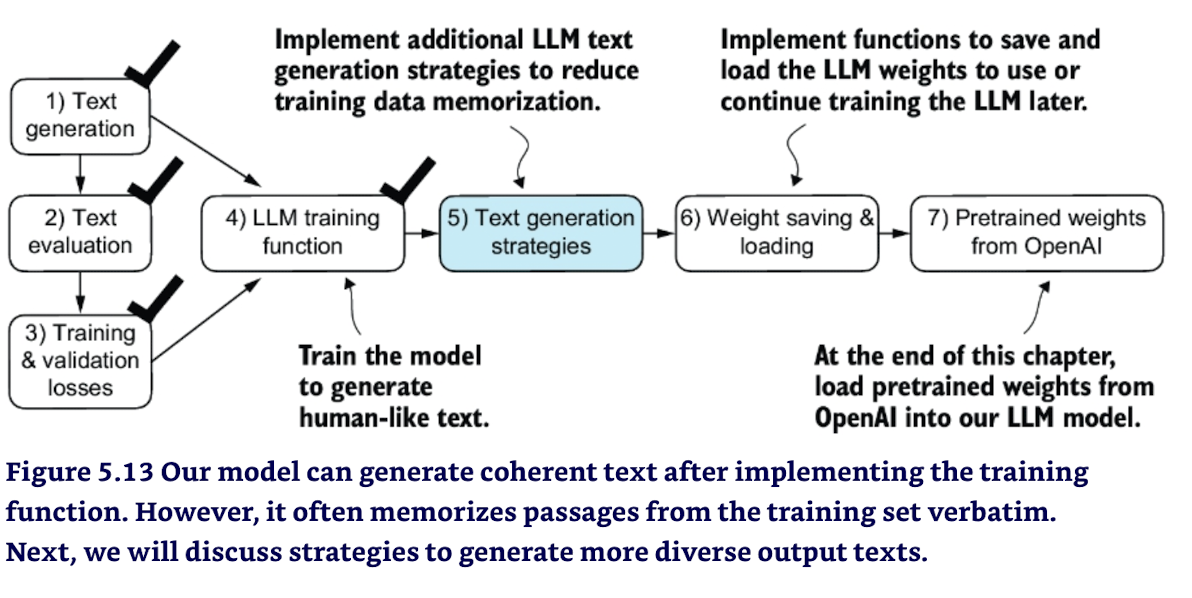

#### Reducing the memomarization

# 5.3 Decoding strategies to control randomness

- Inference is relatively cheap with a relatively small LLM as the GPT model we trained above, so there's no need to use a GPU for it in case you used a GPU for training it above
- Using the `generate_text_simple` function (from the previous chapter) that we used earlier inside the simple training function, we can generate new text one word (or token) at a time
- As explained in section 5.1.2, the next generated token is the token corresponding to the largest probability score among all tokens in the vocabulary

In [ ]:
model.to("cpu")
model.eval() # no dropout

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

- Even if we execute the `generate_text_simple` function above multiple times, the LLM will always generate the same outputs
- We now introduce two concepts, so-called decoding strategies, to modify the `generate_text_simple`: *temperature scaling* and *top-k* sampling
- These will allow the model to control the randomness and diversity of the generated text

### 5.3.1 Temperature Scaling

- Previously, we always sampled the token with the highest probability as the next token using `torch.argmax` --> also called as *greedy decoding*
- To add variety, we can sample the next token using The `torch.multinomial(probs, num_samples=1)`, sampling from a probability distribution
- Here, each index's chance of being picked corresponds to its probability in the input tensor

- Here's a little recap of generating the next token, assuming a very small vocabulary for illustration purposes:


In [ ]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

- The largest probab is 6.75 which is at index 4 i.e you check vocab --> 3 index --> forward

In [ ]:
next_token_logits.shape

In [ ]:
probas

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

In [ ]:
next_token_id

- Function `multinomial` choose most likely words but not always *forward*
- - Instead of determining the most likely token via `torch.argmax`, we use `torch.multinomial(probas, num_samples=1)` to determine the most likely token by sampling from the softmax distribution
- For illustration purposes, let's see what happens when we sample the next token 1,000 times using the original softmax probabilities:

In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

- 582 time forward choosen, but others are also choosen like 73 times closer and 343 times towards.
- - We can control the distribution and selection process via a concept called **temperature scaling**
- ***"Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0***
- Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
- Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- We can see that the rescaling via temperature 0.1 results in a sharper distribution, approaching `torch.argmax`, such that the most likely word is almost always selected:


In [ ]:
print_sampled_tokens(scaled_probas[1])

In [ ]:
print_sampled_tokens(scaled_probas[2])

- Assuming an LLM input "every effort moves you", using the approach above can sometimes result in nonsensical texts, such as "every effort moves you pizza", 3.2% of the time (32 out of 1000 times)

### 5.3.2 Top-k sampling

- To be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens:


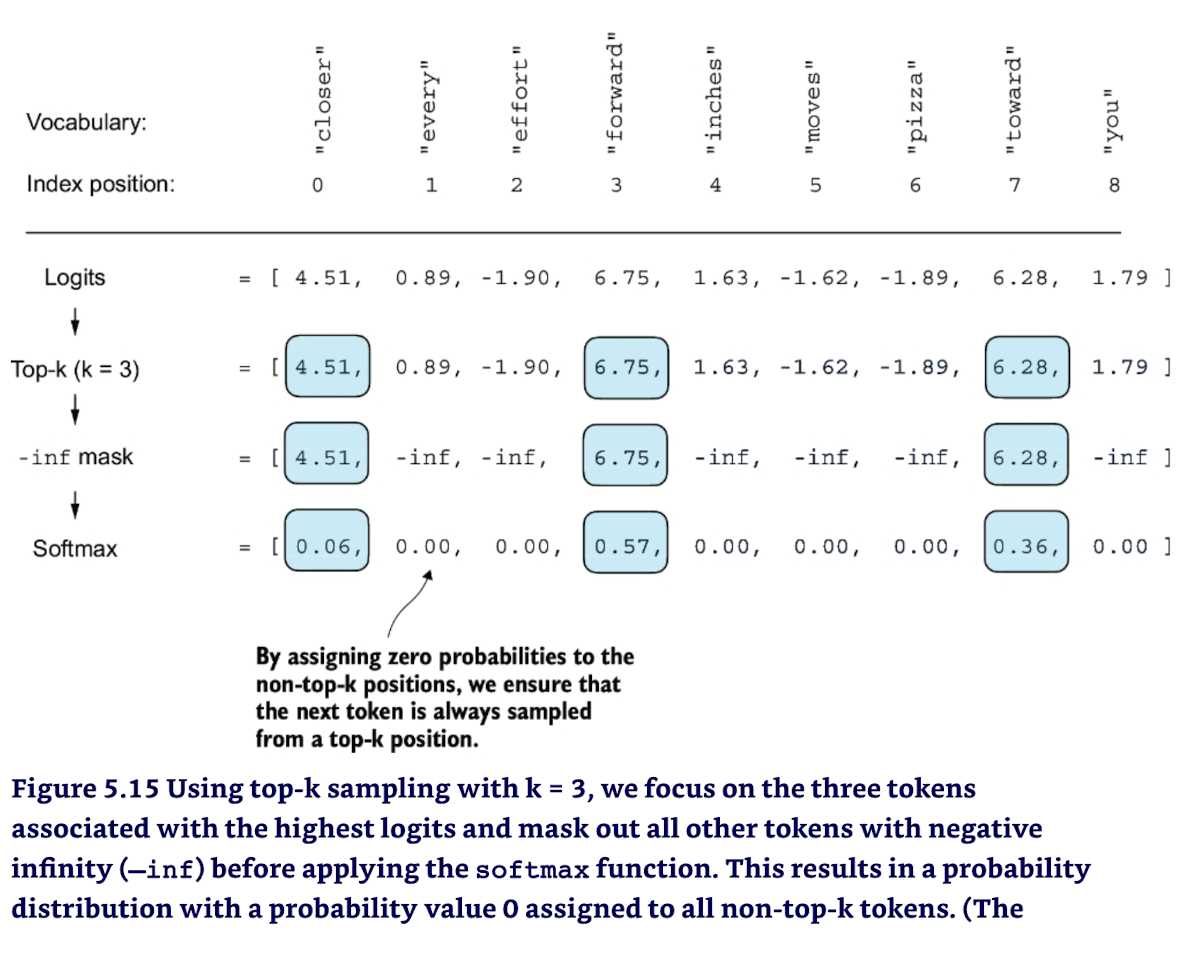

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # Identifies the logits with less than the minimum in the top 3
    input=torch.tensor(float("-inf")),  # assign -inf to those lower
    other=next_token_logits # retain the original logits for all other tokens
)

print(new_logits)

> NOTE:  
>
>  An alternative, slightly more efficient implementation of the previous code cell is the following:
>
> ```python
> new_logits = torch.full_like( # create tensor containing -inf values
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor
> ```
> <br>
> For more details, see https://github.com/rasbt/LLMs-from-scratch/discussions/326

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

- now we can aplly the templature scaling and multinomial,

### 5.3.3 Modifying the text generation

- The previous two subsections introduced temperature sampling and top-k sampling
- Let's use these two concepts to modify the `generate_simple` function we used to generate text via the LLM earlier, creating a new `generate` function:

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

- Very different, as it was memorizing the pessage from the training set before. now its different

# 5.4 Loading and saving model weights in PyTorch

- Training LLMs is computationally expensive, so it's crucial to be able to save and load LLM weights
  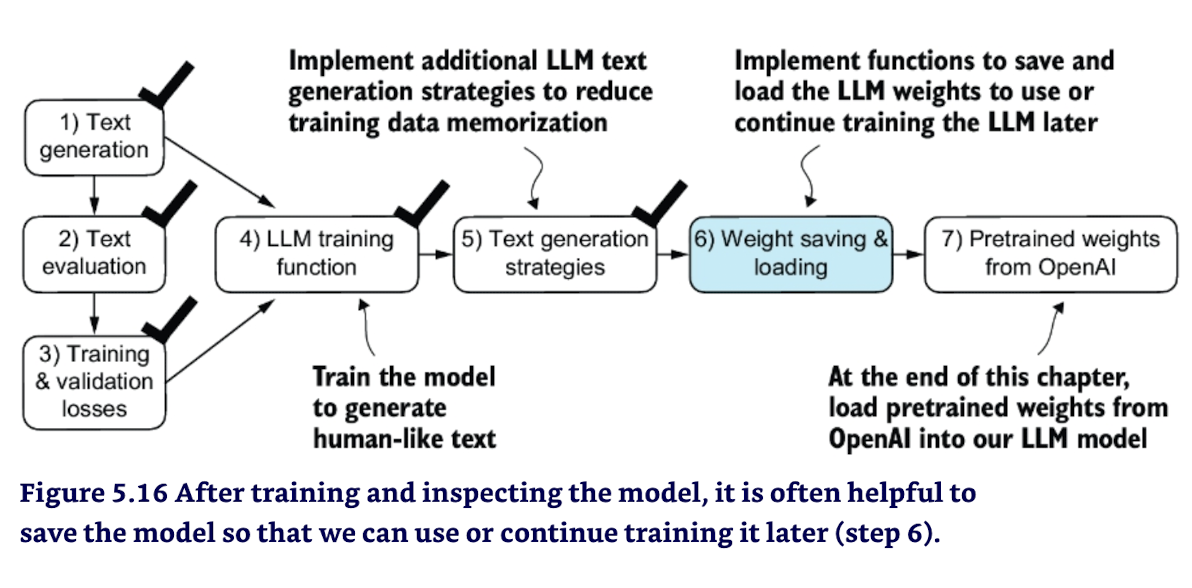

- Recomended way to save the model --> `state_dict` : A dictionary mapping each layer to its parameters using the `torch.save` function.
- 

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location = device))
model.eval()

- If we want to continue training later on the model, `train_model_simple` it is recommended to save `optimizer state` also.
- It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
- These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later:

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", map_location = device)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

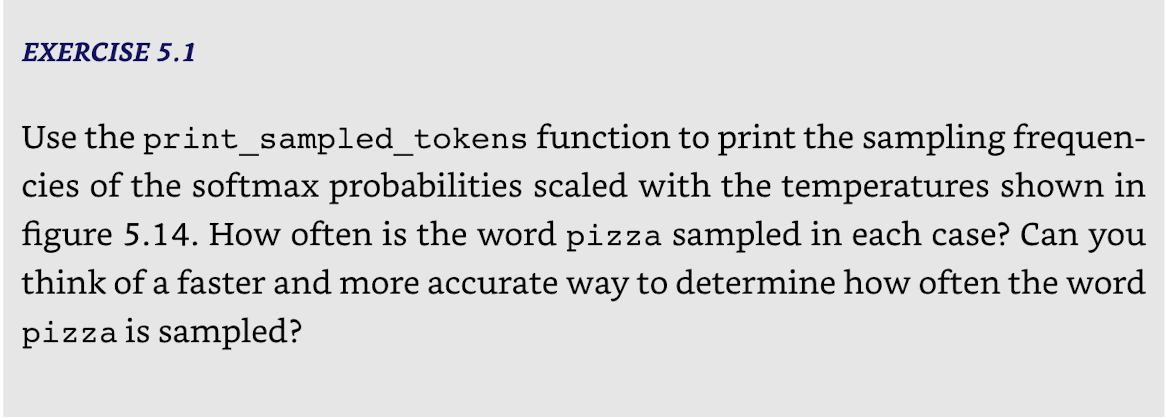

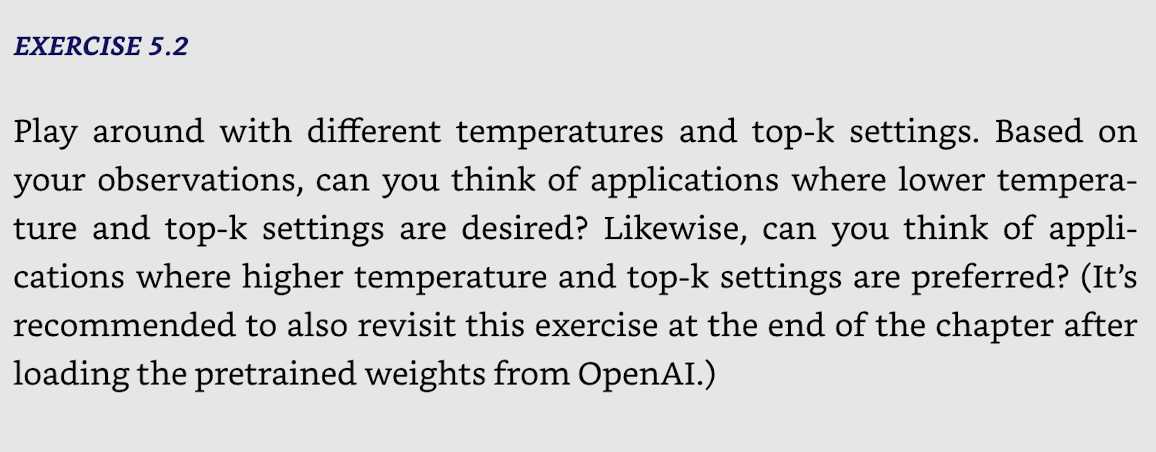

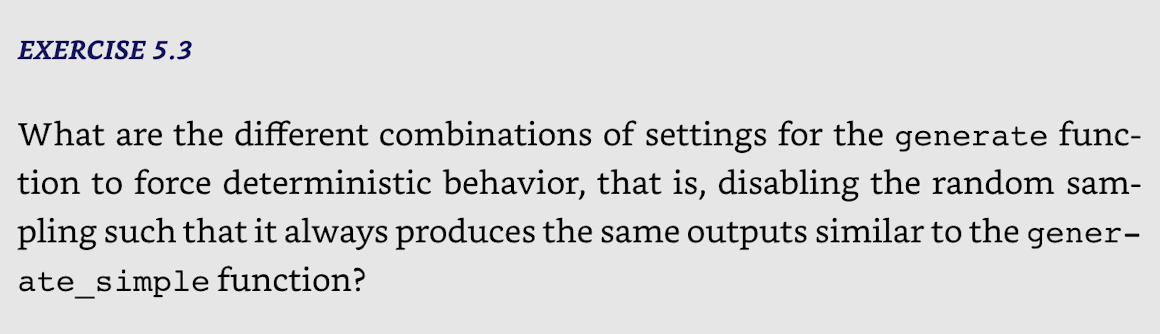

## 5.4 Loading the pretrained weights from OpenAI

- Previously, we only trained a small GPT-2 model using a very small short-story book for educational purposes
- Interested readers can also find a longer pretraining run on the complete Project Gutenberg book corpus in [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)
- Fortunately, we don't have to spend tens to hundreds of thousands of dollars to pretrain the model on a large pretraining corpus but can load the pretrained weights provided by OpenAI

---

---


⚠️ **Note: Some users may encounter issues in this section due to TensorFlow compatibility problems, particularly on certain Windows systems. TensorFlow is required here only to load the original OpenAI GPT-2 weight files, which we then convert to PyTorch.
If you're running into TensorFlow-related issues, you can use the alternative code below instead of the remaining code in this section.
This alternative is based on pre-converted PyTorch weights, created using the same conversion process described in the previous section. For details, refer to the notebook:
[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb) notebook.**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- First, some boilerplate code to download the files from OpenAI and load the weights into Python
- Since OpenAI used [TensorFlow](https://www.tensorflow.org/), we will have to install and use TensorFlow for loading the weights; [tqdm](https://github.com/tqdm/tqdm) is a progress bar library
- Uncomment and run the next cell to install the required libraries

In [39]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [40]:
# Relative import from the gpt_download.py contained in this folder

from gpt_download import download_and_load_gpt2
# Alternatively:
# from llms_from_scratch.ch05 import download_and_load_gpt2

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json


model.ckpt.data-00000-of-00001:   4%|▎      | 21.1M/498M [01:07<17:55, 443kiB/s]